In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import cv2
import csv
from numpy import genfromtxt
import sys
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
# from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12

In [2]:
def get_bounding_box(image):

    _,contours, hierarchy=cv2.findContours(image,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image,(x,y),(x+w,y+h),2)

    # define constrain of bounding box 
    bounding_height_constraint = image.shape[0] * 0.001
    bounding_width_constraint = image.shape[1] * 0.001

    # find letter that satisfied the contrain
    bounding_box = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if (w >= bounding_width_constraint and h >= bounding_height_constraint):
            bounding_box.append([x-1,y-1,w+1,h+1])

    for c in bounding_box:
        x,y,w,h = c
        cv2.rectangle(image,(x,y),(x+w,y+h),1)
    #     plt.imshow(CannyEdge_LP, cmap = 'gray')
    #     plt.show()

    # remove the duplicate
    bounding_box.sort()
    bounding_box = [bounding_box[i] for i in range(len(bounding_box)) if i == 0 or bounding_box[i] != bounding_box[i-1]]
    
    return bounding_box

In [3]:
car = cv2.imread('detector_images/car4.jpeg',0)
car = cv2.medianBlur(car,7)
dst = cv2.cornerHarris(car,2,3,0.04)
dst = cv2.dilate(dst,None)

for i in range(dst.shape[0]):
    for j in range(dst.shape[1]):
        if dst[i][j] < 0:
            dst[i][j] = 0
            
norm_dst = cv2.normalize(dst, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_dst.astype(np.float32)

thres = np.amax(norm_dst) * 0.05

for i in range(norm_dst.shape[0]):
    for j in range(norm_dst.shape[1]):
        if norm_dst[i][j] > thres:
            norm_dst[i][j] = 255
        else:
            norm_dst[i][j] = 0

# ret,thresh = cv2.threshold(norm_dst,0,255,0)
# thresh = np.array(thresh , dtype = np.uint8)
# _,contours, hierarchy=cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
# cv2.drawContours(car, contours, -1, (0,255,0), 3)
# cv2.imwrite('cnt_'+"car.jpg", car)

ret,thresh = cv2.threshold(norm_dst,0,255,0)
thresh = np.array(thresh , dtype = np.uint8)
connectivity = 4 
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)

# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
labels = np.uint8(labels)
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

In [4]:
labels_max = np.amax(labels)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if (labels[i][j] > labels_max * 0.3):
            labels[i][j] = 255
        else:
            labels[i][j] = 0

In [5]:
ret,thresh = cv2.threshold(labels,0,255,0)
thresh = np.array(thresh , dtype = np.uint8)
_,contours, hierarchy=cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
# Concatenate all contours
cnts = np.concatenate(contours)
# Determine and draw bounding rectangle
x , y, w , h = cv2.boundingRect(cnts)
w = w + 15
cv2.rectangle(car, (x, y), (x + w - 1, y + h - 1), (0,255,0), 10)

array([[121, 120, 118, ..., 182, 179, 178],
       [121, 120, 118, ..., 182, 179, 178],
       [120, 120, 118, ..., 182, 180, 178],
       ...,
       [ 95,  95,  95, ..., 111, 111, 111],
       [ 95,  95,  95, ..., 111, 111, 111],
       [ 95,  95,  94, ..., 111, 111, 111]], dtype=uint8)

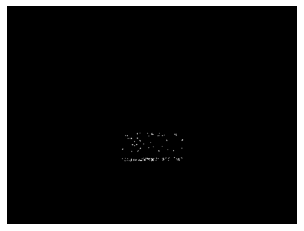

In [6]:
plt.imshow(labels, cmap = 'gray')
plt.axis("off")
plt.show()

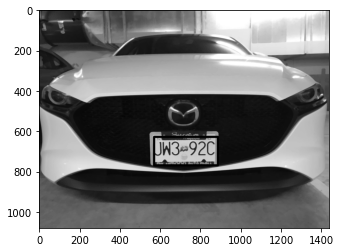

In [7]:
plt.imshow(car, cmap = 'gray')
plt.show()

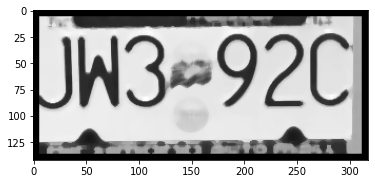

True

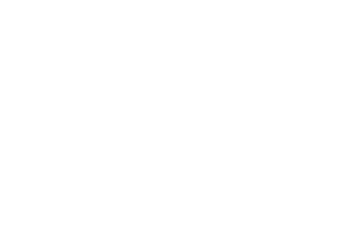

In [8]:
letter = car[y:y+h,x:x+w]
plt.imshow(letter, cmap = 'gray')
plt.show()
plt.axis("off")
cv2.imwrite("output.png", letter)